## **Multi-Linear Perceptron model for Forecasting ML Models**
In this page, the MLP model is trained and tested for stream temperatura prediction considering the air-temperature (Ta), wind (Wind), solar radiation (SR), relative humidity (HR), the day in the year (DY), streamflow (Flow), precipitation (pp), and the shade factor (FS) as predictor variables. The daily stream temperature (Tw) is set as the only response variable.

Clean variables

In [ ]:
### Clean variables
from IPython import get_ipython
get_ipython().magic('reset -sf')

### **Reading of data, process and separation in train and test**

In [ ]:
### Read Data in CSV format for temporal analysis
from pandas import read_csv
import numpy as np

# Dir:  D:\research\ML_model\new_data
raw_d = read_csv('006_sb31_8v_norm_2012_2018.csv', header=0, index_col=0)  # For SB 31
#raw_d = read_csv('006_sb59_8v_norm_2006_2012.csv', header=0, index_col=0) # For SB 59

### Removing/Dropping no-needed variables
data = raw_d.drop(['scenario'],axis=1)
var_tested = list(data.columns.values)
print ("Variables to be tested:", list(data.columns.values)) # Print headers

### convert df pandas to np-array
data = np.asarray(data, dtype=np.float32) # Convert pandas df to np array

### split into Predictor and Response variables
X = data[:, :-1]
y = data[:, -1]
print ("Data dimension (X), (y):", X.shape, y.shape)

# Split into train and test (Random split)
from sklearn.model_selection import train_test_split
# Test-size: 30%, Train-size: 70%
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=1)
print("Training and test data dimensions: \n train_x, train_y, test_x, test_y: \n",
      train_x.shape, test_x.shape, train_y.shape, test_y.shape)

Variables to be tested: ['Ta', 'Wind', 'SR', 'HR', 'DY', 'Flow', 'pp', 'SF', 'Tw']
Data dimension (X), (y): (2511, 8) (2511,)
Training and test data dimensions: 
 train_x, train_y, test_x, test_y: 
 (1757, 8) (754, 8) (1757,) (754,)


### **Tuning of Hyperparameters**
Eleven parameters were tuned:  Activation function,kernel_initializer (initial_weigths), optimizer, learning_rate, n_epochs, batch_size, number of neurons,first set of hidden layers (layers1), second set of hidden layers (layers2), nomalization, and dropout.

Several iterations were performed to find the best set of hyperparameters.

Running this part can take several hours (more than 30 hours in some occasions)

Results are displayed in a table for a better comparison of the performance of hyperparameters.

#### Main libraries

In [ ]:
import random
from numpy import mean, std
from math import sqrt
from keras.layers import Dense, BatchNormalization, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl


#### Search algorithm

In [ ]:
ids = []
act_all, init_w_all, opt_all, l_rate_all, n_epochs_all, batch_size_all = [],[],[],[],[],[]
n_neur_all, layers1_all, layers2_all =[],[],[]
normaliz_d_all, drop_d_all, drop_rate_all = [],[],[]
perfm1, perfm2 = [],[]

n_sim = 10 #   <----------------------------------- SET number of simulation

for i in range(n_sim):
  print ("Set # "+str(i+1)+" in process .................")
  ### Set of parameters -------------------------------------------
  ### Parameters to be Tuned
  ### Activation,init_w,optimizer,learning_rate,batch_size,n_epochs,
  ### n_neur,layers1, layers2, nomaliz, dropout

  ### Hyperparameters
  # 1. Activation selection
  activat_n = ['relu','sigmoid','softplus','softsign','tanh','selu','elu','exponential','LeakyReLU']
  #activat_n = ['relu']
  activat_id = random.randint(0, len(activat_n)-1)
  activat_s = activat_n[activat_id]

  # 2. kernel_initializer (itial_weigths)
  init_w = ['normal','uniform','zeros']
  #init_w = ['uniform']
  init_w_id = random.randint(0, len(init_w)-1)
  init_w_s = init_w[init_w_id]

  # 3 & 4. Optimizer and learning-rate selection

  l_rate = random.randint(1,200)/1000 # 0.005 #
  opt1 = ['SGD', 'Adam', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl']
  #opt1 = ['Adagrad']
  opt_id = random.randint(0, len(opt1)-1)
  opt2= {'Adam':Adam(learning_rate=l_rate), 'SGD':SGD(learning_rate=l_rate),
                  'RMSprop':RMSprop(learning_rate=l_rate), 'Adadelta':Adadelta(learning_rate=l_rate),
                  'Adagrad':Adagrad(learning_rate=l_rate), 'Adamax':Adamax(learning_rate=l_rate),
                  'Nadam':Nadam(learning_rate=l_rate), 'Ftrl':Ftrl(learning_rate=l_rate)}

  #print ("opt_id:",opt_id, ";   Optmzr:", opt2[opt1[opt_id]].__dict__["_name"])

  # 5 & 6. n_epochs, batch_size,
  n_epochs = random.randint(100, 1500) # 1500 #
  batch_size = random.randint(100, 300) # 100 #

  # 7. number of neurons
  n_neur = random.randint(100, 300) # 250 #

  # 8 & 9 number of layers
  layers1 = random.randint(0, 3) # 1 #
  layers2 = random.randint(0, 3) # 1 #

  # 10. nomalization
  normaliz_d = random.randint(0, 1) # 1 #

  # 11. dropout
  drop_d = random.randint(0, 1) # 1 #
  drop_rate = random.randint(50, 80)/100 # 0.5 - 0.8 good values
  ### End set of parameters -----------------------------


  #params = [activationL, init_weight, optimizerL, n_epochs, batch_size, learning_rate]
  n_input = len(train_x[0]) # Number of input variables
  model = Sequential()
  ### Hidden layer 0
  model.add(Dense(n_neur, activation = activat_s, input_dim=n_input, kernel_initializer =init_w_s))# 'uniform'))

  if normaliz_d > 0.5:
    model.add(BatchNormalization())

  ### Hidden layer 1
  for j in range(layers1):
    model.add(Dense(n_neur, activation = activat_s))
    #model.add(Dense(n_neur, activation = activat_s))
    #model.add(Dense(n_neur, activation = activat_s))

  if drop_d > 0.5:
    model.add(Dropout(drop_rate, seed=123))

  ### Hidden layer 2
  for j in range(layers2):
    model.add(Dense(n_neur, activation = activat_s))
    #model.add(Dense(n_neur, activation = activat_s))

  ### Output layer
  model.add(Dense(1)) #model.add(Dense(1, activation='sigmoid'))
  #model.compile(loss='mse', optimizer=params[2]) # Compiling the model
  #model.compile(loss='mse', optimizer=Adam(learning_rate = l_rate)) # 0.8279
  model.compile(loss='mse', optimizer = opt2[opt1[opt_id]]) # 0.8279

  ### Fit the ML-Perceptron model

  # More about 'EarlyStopping': https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
  # "batch_size" must be > 1 and < n_samples. Ref: https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/
  early_stop = EarlyStopping(monitor='loss', patience=20, verbose=1, mode='auto') #We will wait 'patience=10' epochs before training is stopped
  hist_model = model.fit(train_x, train_y,validation_data=(test_x, test_y),
                        epochs=n_epochs, batch_size=batch_size, verbose=0, callbacks=[early_stop])
  #print(hist_model.history['loss']) # Get list of 'loss' at each epoch
  #all_loss.append(hist_model.history['loss']) # For other error reports see: https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
  #all_val_loss.append(hist_model.history['val_loss']) # This loss is from the 'test' data

  #print (i+1)
  print (activat_id, activat_n[activat_id])
  print (init_w_id, init_w[init_w_id])
  print (opt_id, opt2[opt1[opt_id]].__dict__["_name"])
  print ("learning_rate:", l_rate)
  print ("n_epochs, batch_size:", n_epochs, batch_size)
  print ("neurons, L1, L2: ", n_neur, layers1, layers2)
  #print ("nomalztn:", normaliz_d)
  print ("nomalztn:", ("Yes" if normaliz_d else "No"))
  #print ("Dropout:", drop_d, drop_rate)
  print ("Dropout:", ("Yes" if drop_d else "No"), " ", (drop_rate if drop_d else ""))
  print ("Performance", round(hist_model.history['loss'][-1],4)," ", round(hist_model.history['val_loss'][-1],4))
  print ()

  ids.append(str(i+1))
  act_all.append(activat_n[activat_id])
  init_w_all.append(init_w[init_w_id])
  opt_all.append(opt2[opt1[opt_id]].__dict__["_name"])
  l_rate_all.append(l_rate)
  n_epochs_all.append(n_epochs)
  batch_size_all.append(batch_size)
  n_neur_all.append(n_neur)
  layers1_all.append(layers1)
  layers2_all.append(layers2)
  normaliz_d_all.append("Yes" if normaliz_d else "No")
  drop_d_all.append("Yes" if drop_d else "No")
  drop_rate_all.append(drop_rate)
  perfm1.append(round(hist_model.history['loss'][-1],3))
  perfm2.append(round(hist_model.history['val_loss'][-1],3))


#### Results of the search

In [ ]:
### Print results of tuning
headers = ['ID', 'Train_err','Test_err','Activat','weights', 'optimz','learning_r','Epochs','Batch',
           'Neurons','Layers1','Layers2','Normalzn','Dropout','Drop_r']
scores = [ids, perfm1, perfm2, act_all, init_w_all, opt_all, l_rate_all,
      n_epochs_all, batch_size_all, n_neur_all, layers1_all,
      layers2_all, normaliz_d_all, drop_d_all, drop_rate_all
      ]
scores_t = list(map(list, zip(*scores)))
#print (scores_t)

from tabulate import tabulate
print(tabulate(scores_t, headers = headers, tablefmt = 'orgtbl'))


|   ID |   Train_err |   Test_err | Activat     | weights   | optimz   |   learning_r |   Epochs |   Batch |   Neurons |   Layers1 |   Layers2 | Normalzn   | Dropout   |   Drop_r |
|------+-------------+------------+-------------+-----------+----------+--------------+----------+---------+-----------+-----------+-----------+------------+-----------+----------|
|    1 |       2.33  |      2.512 | softsign    | normal    | Adagrad  |        0.005 |      580 |     177 |       211 |         0 |         1 | Yes        | Yes       |     0.79 |
|    2 |       1.375 |      1.229 | elu         | zeros     | RMSprop  |        0.005 |      720 |     196 |       150 |         0 |         1 | No         | Yes       |     0.69 |
|    3 |       1.473 |      0.905 | softplus    | uniform   | RMSprop  |        0.005 |     7230 |     204 |       180 |         1 |         3 | No         | Yes       |     0.65 |
|    4 |       4.489 |      7.942 | elu         | zeros     | RMSprop  |        0.005 |      45

### **Modeling employing the tuned parameters (best parameters)**
From the previous step, we got that the set of parameters #8 provides the best performance.

In [ ]:
### Read Data in CSV format for temporal analysis
from pandas import read_csv
import numpy as np

# Dir:  D:\research\ML_model\new_data
#raw_d = read_csv('006_sb31_8v_norm_2012_2018.csv', header=0, index_col=0)  # For SB 31
raw_d = read_csv('002_sb31_norm_2012_2017_for_train_test.csv', header=0, index_col=0)  # For SB 31
#raw_d = read_csv('006_sb59_8v_norm_2006_2012.csv', header=0, index_col=0) # For SB 59

### Removing/Dropping no-needed variables
data = raw_d.drop(['scenario'],axis=1)
var_tested = list(data.columns.values)
print ("Variables to be tested:", list(data.columns.values)) # Print headers

### convert df pandas to np-array
data = np.asarray(data, dtype=np.float32) # Convert pandas df to np array

### split into Predictor and Response variables
X = data[:, :-1]
y = data[:, -1]
print ("Data dimension (X), (y):", X.shape, y.shape)

# Split into train and test (Random split)
from sklearn.model_selection import train_test_split
# Test-size: 30%, Train-size: 70%
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=1)
print("Training and test data dimensions: \n train_x, train_y, test_x, test_y: \n",
      train_x.shape, test_x.shape, train_y.shape, test_y.shape)

Variables to be tested: ['Ta', 'Wind', 'SR', 'HR', 'DY', 'Flow', 'pp', 'SF', 'Tw']
Data dimension (X), (y): (6438, 8) (6438,)
Training and test data dimensions: 
 train_x, train_y, test_x, test_y: 
 (4506, 8) (1932, 8) (4506,) (1932,)


#### Setting the MLP model with the best parameters.
This has to be manually set

In [ ]:
### MLP-Model definition with best parameters (This setting is not automatically updated)
def best_nn_model(n_inp):
  act_win = 'LeakyReLU'
  weight_win = 'uniform'

  n_input = n_inp #len(train_x[0]) # Number of input variables
  b_model = Sequential()
  ### Input layer 0
  b_model.add(Dense(250, activation = act_win, input_dim=n_input, kernel_initializer = weight_win))
  #b_model.add(BatchNormalization())

  ### Hidden layer 1
  #b_model.add(Dense(250, activation = act_win))
  #b_model.add(Dense(250, activation = act_win))
  #b_model.add(Dense(250, activation = act_win))
  #model.add(Dropout(drop_rate, seed=123))

  ### Hidden layer 2
  b_model.add(Dense(250, activation = act_win))
  b_model.add(Dense(250, activation = act_win))
  #b_model.add(Dense(250, activation = act_win))

  ### Output layer
  b_model.add(Dense(1))

  #b_model.compile(loss='mse', optimizer=Adagrad(learning_rate = 0.005))
  b_model.compile(loss='mse', optimizer=Adamax(learning_rate = 0.005))
  return b_model

#### Setting the process to repeat the model for different sets of predictors
20 repetitions were conducted for each set of predictors.

In [ ]:
from termcolor import colored
from sklearn.model_selection import train_test_split

data = raw_d.drop(['scenario'],axis=1)
'''
set1 = data[['Ta','Tw']]
set2 = data[['Ta','Flow','Tw']]
set3 = data[['Ta','Flow','DY','Tw']]
set4 = data[['Ta','Flow','DY','SF','Tw']]
set5 = data[['Ta','Flow','DY','SF','SR','Tw']]
set6 = data[['Ta','Flow','DY','SF','SR','pp','Tw']]
set7 = data[['Ta','Flow','DY','SF','SR','pp','HR','Tw']]
set8 = data[['Ta','Flow','DY','SF','SR','pp','HR','Wind','Tw']]
set9 = data[['Ta','DY','SF','SR','pp','HR','Wind','Tw']]
set10 = data[['Ta','DY','pp','Tw']]
set11 = data[['Ta','DY','Tw']] #'''

set1 = data[['Ta','Flow','Tw']]
set2 = data[['Ta','DY','Tw']]
set3 = data[['Ta','SF','Tw']]
set4 = data[['Ta','SR','Tw']]
set5 = data[['Ta','pp','Tw']]
set6 = data[['Ta','HR','Tw']]
set7 = data[['Ta','Wind','Tw']]

#sets = [set1,set2,set3,set4,set5,set6,set7,set8,set9,set10,set11]
sets = [set1,set2,set3,set4,set5,set6,set7]
labels=[str(r) for r in sets]
sets_names = [f'M{i}' for i in range(1, 12)]
#print("Models to be tested: ", sets_names)

names = [['Ta','Tw'],['Ta','Flow','Tw'],['Ta','Flow','DY','Tw'],['Ta','Flow','DY','SF','Tw'],['Ta','Flow','DY','SF','SR','Tw']
         ,['Ta','Flow','DY','SF','SR','pp','Tw'],['Ta','Flow','DY','SF','SR','pp','HR','Tw']
         ,['Ta','Flow','DY','SF','SR','pp','HR','Wind','Tw'],['Ta','DY','SF','SR','pp','HR','Wind','Tw']
         ,['Ta','DY','pp','Tw'],['Ta','DY','Tw']]
names = [['Ta','Flow','Tw'],['Ta','DY','Tw'],['Ta','SF','Tw'],['Ta','SR','Tw'],['Ta','pp','Tw']
         ,['Ta','HR','Tw'],['Ta','Wind','Tw']
         ]

all_sets = []
ccc = 0
for sett in sets:
  #print ("Model M"+str(ccc+1)+"......", 'red')
  print (colored("Model M"+str(ccc+1)+"......"+str(names[ccc][:-1]), 'red'))
  sett = np.asarray(sett, dtype=np.float32) # Convert pandas df to np array

  ### split into Predictor and Response variables
  Xn = sett[:, :-1]
  yn = sett[:, -1]
  print ("Data dimension (Xn), (yn):", Xn.shape, yn.shape)

  # Split into train and test (Random split)

  # Test-size: 30%, Train-size: 70%
  train_xn, test_xn, train_yn, test_yn = train_test_split(Xn, yn, test_size=0.3, random_state=1)
  print("Training and test data dimensions: \n train_x, train_y, test_x, test_y: \n",
        train_xn.shape, test_xn.shape, train_yn.shape, test_yn.shape)
  #print ("train_data:",train_xn)
  #print ("train_y:",train_yn)

  n_epochs = 1500   #  <-----  you might SET
  batch_size = 64 #

  all_loss, all_val_loss = [],[]
  all_preds, all_scores_train, all_scores_test = [], [], []

  n_repeats = 2 #20  #     <----------------------- SET
  for i in range(n_repeats):
    print ("Sim", i+1)
    b_model = best_nn_model(len(train_xn[0]))   #  -----> Function model
    early_stop = EarlyStopping(monitor='loss', patience=20, verbose=1, mode='auto') #We will wait 'patience=10' epochs before training is stopped

    hist_model = b_model.fit(train_xn, train_yn,validation_data=(test_xn, test_yn),
                          epochs=n_epochs, batch_size=batch_size, verbose=0, callbacks=[early_stop])
    #print(hist_model.history['loss']) # Get list of 'loss' at each epoch
    all_loss.append(hist_model.history['loss']) # For other error reports see: https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
    all_val_loss.append(hist_model.history['val_loss']) # This loss is from the 'test' data

    print ("Loss (MSE):   ", hist_model.history['loss'][-1]) # This is MSE for train
    print ("Val_loss (MSE):", hist_model.history['val_loss'][-1]) # This is MSE for test


    ### Prediction
    ### Prediction on train
    pred_yn_train = b_model.predict(train_xn, verbose=0)
    pred_yn_train_flat = [item for sublist in pred_yn_train.tolist() for item in sublist]
    #print ("Prediction on train data (Sim",i+1, ") \n", pred_yn_train_flat)
    all_preds.append(pred_yn_train_flat)
    #print (dasda)
    #pred_y_test_flat.to_csv('predict.csv')  # save updated dataset

    # Prediction Error. Root mean squared error or RMSE
    error_train = sqrt(mean_squared_error(train_yn, pred_yn_train))#error = measure_rmse(test, predictions)
    #print("RMSE train (sim",i+1,"):",'  %.3f' % error_train) #E:

    all_scores_train.append(error_train) #all_scores.append(scores)
    #print (all_scores_train)

    ### Prediction on test
    pred_yn_test = b_model.predict(test_xn, verbose=0)
    pred_yn_test_flat = [item for sublist in pred_yn_test.tolist() for item in sublist]
    #print ("Prediction on test data (Sim",i+1, ") \n", pred_yn_test_flat)
    all_preds.append(pred_yn_test_flat)
    #print (dasdsa)
    #pred_y_test_flat.to_csv('predict.csv')  # save updated dataset

    # Prediction Error. Root mean squared error or RMSE
    error_test = sqrt(mean_squared_error(test_yn, pred_yn_test))#error = measure_rmse(test, predictions)
    #print("RMSE test(sim",i+1,"):",'   %.3f' % error_test) #E:

    all_scores_test.append(error_test) #all_scores.append(scores)
    #print (all_scores_test)
    #print (ewewe)

  #print ("Tested variables (Header):", var_tested) # print column names
  # summarize and plot scores
  print ("Note: loss is MSE")
  scores_m, score_std = mean(all_scores_test), std(all_scores_test)
  print('%s: %.3f RMSE_avge (+/- %.3f)' % ('Average of '+str(n_repeats)+" repetitions", scores_m, score_std))

  all_sets.append(all_scores_test) #Store scores of all models (M1, M2,...) as list od lists
  print ()
  ccc += 1


#### Save output to CSV file

In [ ]:
### Save output data as CSV file
from google.colab import files
import pandas as pd
scores_df = pd.DataFrame(all_sets)
scores_df.to_csv('SB31_mlp_output_11models.csv')
#scores_all_models

#### Plot of Performance of the tested models with the different sets of predictors

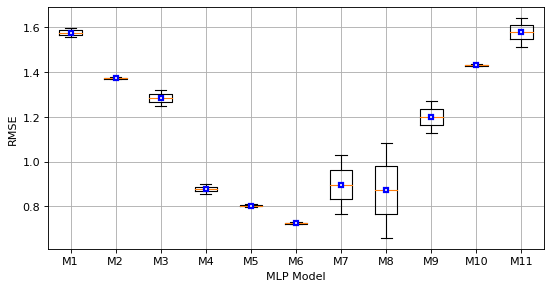

In [ ]:
### Plot of results
import matplotlib.pyplot as plt
scores_all_models = all_sets
#sets_names = ['M1','M2','M3','M4','M5','M6','M7','M8','M9','M10','M11']
### Plot performance of all the models
fig = plt.figure(figsize=(8, 4), dpi=80)
plt.boxplot(scores_all_models, labels=sets_names, showmeans=1,
            meanprops={"marker":"s","markersize":"4","markerfacecolor":"white",
                       "markeredgecolor":"blue", "markeredgewidth":"2"})

plt.xlabel("MLP Model")
plt.ylabel("RMSE")
plt.grid()
plt.show()

### **Feasible area employing the tuned parameters**

In [ ]:
import random
from numpy import mean, std
from math import sqrt
from keras.layers import Dense, BatchNormalization, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl

In [ ]:
### Clean variables
from IPython import get_ipython
get_ipython().magic('reset -sf')

In [ ]:
### Read Data in CSV format for temporal analysis
from pandas import read_csv
import numpy as np

# Dir:  D:\research\ML_model\new_data
#raw_d = read_csv('006_sb31_8v_norm_2012_2018.csv', header=0, index_col=0)  # For SB 31
#raw_d = read_csv('002_sb31_norm_2012_2017_for_train_test.csv', header=0, index_col=0)  # For SB 31
raw_d = read_csv('004_sb59_norm_2006_2011_for_train_test.csv', header=0, index_col=0)  # For SB 31
#raw_d = read_csv('006_sb59_8v_norm_2006_2012.csv', header=0, index_col=0) # For SB 59

### Removing/Dropping no-needed variables
data = raw_d.drop(['scenario'],axis=1)
var_tested = list(data.columns.values)
print ("Variables to be tested:", list(data.columns.values)) # Print headers

### convert df pandas to np-array
data = np.asarray(data, dtype=np.float32) # Convert pandas df to np array

### split into Predictor and Response variables
X = data[:, :-1]
y = data[:, -1]
print ("Data dimension (X), (y):", X.shape, y.shape)

# Split into train and test (Random split)
from sklearn.model_selection import train_test_split
# Test-size: 30%, Train-size: 70%
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=1)
print("Training and test data dimensions: \n train_x, train_y, test_x, test_y: \n",
      train_x.shape, test_x.shape, train_y.shape, test_y.shape)

Variables to be tested: ['Ta', 'Wind', 'SR', 'HR', 'DY', 'Flow', 'pp', 'SF', 'Tw_59']
Data dimension (X), (y): (5850, 8) (5850,)
Training and test data dimensions: 
 train_x, train_y, test_x, test_y: 
 (4095, 8) (1755, 8) (4095,) (1755,)


In [ ]:
### MLP-Model definition with best parameters (This setting is not automatically updated)
def best_nn_model(n_inp):
  act_win = 'LeakyReLU'
  weight_win = 'uniform'

  n_input = n_inp #len(train_x[0]) # Number of input variables
  b_model = Sequential()
  ### Input layer 0
  b_model.add(Dense(250, activation = act_win, input_dim=n_input, kernel_initializer = weight_win))
  #b_model.add(BatchNormalization())

  ### Hidden layer 1
  #b_model.add(Dense(250, activation = act_win))
  #b_model.add(Dense(250, activation = act_win))
  #b_model.add(Dense(250, activation = act_win))
  #model.add(Dropout(drop_rate, seed=123))

  ### Hidden layer 2
  b_model.add(Dense(250, activation = act_win))
  b_model.add(Dense(250, activation = act_win))
  #b_model.add(Dense(250, activation = act_win))

  ### Output layer
  b_model.add(Dense(1))

  #b_model.compile(loss='mse', optimizer=Adagrad(learning_rate = 0.005))
  b_model.compile(loss='mse', optimizer=Adamax(learning_rate = 0.005))
  return b_model


In [ ]:
### Get combination of children
import itertools, copy, heapq

data = raw_d.drop(['scenario'],axis=1)

n_vars = 8
root = ['Ta']
listvar = ['Flow', 'DY', 'SF','SR','pp','HR','Wind']
listvar2 = copy.deepcopy(listvar)
c72 = list(itertools.combinations(listvar2,n_vars-1))
print (c72)
print (len(c72))
set_n = []
sets = []
for sid in c72:
  #nnsid = root + list(sid)+['Tw']
  nnsid = root + list(sid)+['Tw_59']
  print ("set_of_vars:", nnsid)
  set_n.append(nnsid)
  st_d = data[nnsid]
  sets.append(st_d)

print (len(sets))


[('Flow', 'DY', 'SF', 'SR', 'pp', 'HR', 'Wind')]
1
set_of_vars: ['Ta', 'Flow', 'DY', 'SF', 'SR', 'pp', 'HR', 'Wind', 'Tw_59']
1


In [ ]:
st22 = ['Ta', 'DY', 'SR', 'Wind', 'Tw_59']
st23 = ['Ta', 'DY', 'pp', 'HR', 'Tw_59']
st24 = ['Ta', 'DY', 'pp', 'Wind', 'Tw_59']
st25 = ['Ta', 'DY', 'HR', 'Wind', 'Tw_59']
st26 =  ['Ta', 'SF', 'SR', 'pp', 'Tw_59']
st27 =  ['Ta', 'SF', 'SR', 'HR', 'Tw_59']
st28 =  ['Ta', 'SF', 'SR', 'Wind', 'Tw_59']
st29 =  ['Ta', 'SF', 'pp', 'HR', 'Tw_59']
st30 =  ['Ta', 'SF', 'pp', 'Wind', 'Tw_59']
st31 =  ['Ta', 'SF', 'HR', 'Wind', 'Tw_59']
st32 =  ['Ta', 'SR', 'pp', 'HR', 'Tw_59']
st33 =  ['Ta', 'SR', 'pp', 'Wind', 'Tw_59']
st34 =  ['Ta', 'SR', 'HR', 'Wind', 'Tw_59']
st35 =  ['Ta', 'pp', 'HR', 'Wind', 'Tw_59']

set_n = [st22, st23, st24, st25, st26, st27, st28, st29, st30
         ,st31, st32, st33, st34, st35]

st_d22 = data[st22]
st_d23 = data[st23]
st_d24 = data[st24]
st_d25 = data[st25]
st_d26 = data[st26]
st_d27 = data[st27]
st_d28 = data[st28]
st_d29 = data[st29]
st_d30 = data[st30]
st_d31 = data[st31]
st_d32 = data[st32]
st_d33 = data[st33]
st_d34 = data[st34]
st_d35 = data[st35]

sets = [st_d22, st_d23, st_d24, st_d25, st_d26, st_d27, st_d28, st_d29, st_d30
         ,st_d31, st_d32, st_d33, st_d34, st_d35]


In [ ]:
from termcolor import colored
from sklearn.model_selection import train_test_split

data = raw_d.drop(['scenario'],axis=1)

#sets = [set1,set2,set3,set4,set5,set6,set7,set8,set9,set10,set11]
#sets = [set4]
labels=[str(r) for r in sets]
sets_names = [f'M{i}' for i in range(1, 12)]
#print("Models to be tested: ", sets_names)

names = set_n

scores_all_test_sets = []
scores_all_train_sets = []
ccc = 0
for sett in sets:
  #print ("Model M"+str(ccc+1)+"......", 'red')
  print (colored("Model M"+str(ccc+1)+"......"+str(names[ccc][:-1]), 'red'))
  sett = np.asarray(sett, dtype=np.float32) # Convert pandas df to np array

  ### split into Predictor and Response variables
  Xn = sett[:, :-1]
  yn = sett[:, -1]
  print ("Data dimension (Xn), (yn):", Xn.shape, yn.shape)

  # Split into train and test (Random split)

  # Test-size: 30%, Train-size: 70%
  train_xn, test_xn, train_yn, test_yn = train_test_split(Xn, yn, test_size=0.3, random_state=1)
  print("Training and test data dimensions: \n train_x, train_y, test_x, test_y: \n",
        train_xn.shape, test_xn.shape, train_yn.shape, test_yn.shape)
  #print ("train_x:",train_xn)
  #print ("train_y:",train_yn)

  n_epochs = 1500   #  <-----  you might SET
  batch_size = 100

  all_loss, all_val_loss = [],[]
  all_preds, all_scores_train, all_scores_test = [], [], []

  n_repeats = 5 #20  #     <----------------------- SET
  for i in range(n_repeats):
    print ("Sim", i+1)
    b_model = best_nn_model(len(train_xn[0]))   #  -----> Function model
    early_stop = EarlyStopping(monitor='loss', patience=20, verbose=1, mode='auto') #We will wait 'patience=10' epochs before training is stopped
    hist_model = b_model.fit(train_xn, train_yn,validation_data=(test_xn, test_yn),
                          epochs=n_epochs, batch_size=batch_size, verbose=0, callbacks=[early_stop])
    #print(hist_model.history['loss']) # Get list of 'loss' at each epoch
    all_loss.append(hist_model.history['loss']) # For other error reports see: https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
    all_val_loss.append(hist_model.history['val_loss']) # This loss is from the 'test' data

    print ("Loss (MSE):   ", hist_model.history['loss'][-1]) # This is MSE for train
    print ("Val_loss (MSE):", hist_model.history['val_loss'][-1]) # This is MSE for test


    ### Prediction
    ### Prediction on train
    pred_yn_train = b_model.predict(train_xn, verbose=0)
    pred_yn_train_flat = [item for sublist in pred_yn_train.tolist() for item in sublist]
    #print ("Prediction on train data (Sim",i+1, ") \n", pred_yn_train_flat)
    all_preds.append(pred_yn_train_flat)
    #print (dasda)
    #pred_y_test_flat.to_csv('predict.csv')  # save updated dataset

    # Prediction Error. Root mean squared error or RMSE
    error_train = sqrt(mean_squared_error(train_yn, pred_yn_train))#error = measure_rmse(test, predictions)
    #print("RMSE train (sim",i+1,"):",'  %.3f' % error_train) #E:

    all_scores_train.append(error_train) #all_scores.append(scores)
    #print (all_scores_train)

    ### Prediction on test
    pred_yn_test = b_model.predict(test_xn, verbose=0)
    pred_yn_test_flat = [item for sublist in pred_yn_test.tolist() for item in sublist]
    #print ("Prediction on test data (Sim",i+1, ") \n", pred_yn_test_flat)
    all_preds.append(pred_yn_test_flat)
    #print (dasdsa)
    #pred_y_test_flat.to_csv('predict.csv')  # save updated dataset

    # Prediction Error. Root mean squared error or RMSE
    error_test = sqrt(mean_squared_error(test_yn, pred_yn_test))#error = measure_rmse(test, predictions)
    #print("RMSE test(sim",i+1,"):",'   %.3f' % error_test) #E:

    all_scores_test.append(error_test) #all_scores.append(scores)
    #print (all_scores_test)
    #print (ewewe)

  #print ("Tested variables (Header):", var_tested) # print column names
  # summarize and plot scores
  print ("Note: loss is MSE")
  scores_m, score_std = mean(all_scores_test), std(all_scores_test)
  print('%s: %.3f RMSE_avge (+/- %.3f)' % ('Average of '+str(n_repeats)+" repetitions", scores_m, score_std))

  scores_all_train_sets.append(all_scores_train) #Store scores of all models (M1, M2,...) as list od lists
  scores_all_test_sets.append(all_scores_test) #Store scores of all models (M1, M2,...) as list od lists
  print ()
  ccc += 1

print (scores_all_train_sets)
print (scores_all_test_sets)

Model M1......['Ta', 'Flow', 'DY', 'SF', 'SR', 'pp', 'HR', 'Wind']
Data dimension (Xn), (yn): (5850, 8) (5850,)
Training and test data dimensions: 
 train_x, train_y, test_x, test_y: 
 (4095, 8) (1755, 8) (4095,) (1755,)
Sim 1
Epoch 141: early stopping
Loss (MSE):    0.8038082718849182
Val_loss (MSE): 0.8468785285949707
Sim 2
Epoch 423: early stopping
Loss (MSE):    0.4559570848941803
Val_loss (MSE): 0.706658124923706
Sim 3
Epoch 465: early stopping
Loss (MSE):    0.36168575286865234
Val_loss (MSE): 0.5864307284355164
Sim 4
Epoch 345: early stopping
Loss (MSE):    0.5108231902122498
Val_loss (MSE): 0.7359461188316345
Sim 5
Epoch 364: early stopping
Loss (MSE):    0.494468092918396
Val_loss (MSE): 0.7286659479141235
Note: loss is MSE
Average of 5 repetitions: 0.848 RMSE_avge (+/- 0.049)

[[0.875639341292745, 0.6816903344859014, 0.5951431143571235, 0.7390927088815922, 0.7195971927806473]]
[[0.920260065524749, 0.8406296003137803, 0.765787691230514, 0.8578730202259741, 0.853619287685956]]


In [ ]:
print (scores_all_train_sets)
print (scores_all_test_sets)

[[0.9342634600148738, 0.8827778632196837, 0.874309130812743, 0.8494192678046883, 0.8328752848306805], [0.9993820367199177, 0.8248822402717277, 0.8074815629324675, 0.9172226166379335, 0.9470017842434084], [1.0360942117905454, 0.9100824743666827, 0.849840856127433, 0.9098772595494521, 0.9406048541272078], [0.9723866100449368, 0.942659675368085, 0.9100736981720676, 0.9034234725195656, 0.935317519072816], [1.1178179475919772, 1.0937217708759448, 1.1191380152913235, 1.062407545667302, 1.2117619814806713], [1.128091485114772, 1.0968471817010303, 1.1220565542733816, 1.154323622753495, 1.101462122895805], [1.114304617618379, 1.055790303434086, 1.0327540901969265, 1.0806448417152517, 1.1025173837238436], [1.1452056668404167, 1.0781224568654901, 1.2957791673842949, 1.1377960553404458, 1.1342798135297854], [1.0816531295301537, 1.250631125386044, 1.0991957650563924, 1.092449177622683, 1.0733350413370069], [1.1058236351153268, 1.1668600989249982, 1.1331944841057418, 1.1841234085876087, 1.2206263159

In [ ]:
from termcolor import colored
from sklearn.model_selection import train_test_split

data = raw_d.drop(['scenario'],axis=1)

#sets = [set1,set2,set3,set4,set5,set6,set7,set8,set9,set10,set11]
#sets = [set4]
labels=[str(r) for r in sets]
sets_names = [f'M{i}' for i in range(1, 12)]
#print("Models to be tested: ", sets_names)

names = set_n

scores_all_test_sets = []
scores_all_train_sets = []
ccc = 0
for sett in sets:
  #print ("Model M"+str(ccc+1)+"......", 'red')
  print (colored("Model M"+str(ccc+1)+"......"+str(names[ccc][:-1]), 'red'))
  sett = np.asarray(sett, dtype=np.float32) # Convert pandas df to np array

  ### split into Predictor and Response variables
  Xn = sett[:, :-1]
  yn = sett[:, -1]
  print ("Data dimension (Xn), (yn):", Xn.shape, yn.shape)

  # Split into train and test (Random split)

  # Test-size: 30%, Train-size: 70%
  train_xn, test_xn, train_yn, test_yn = train_test_split(Xn, yn, test_size=0.3, random_state=1)
  print("Training and test data dimensions: \n train_x, train_y, test_x, test_y: \n",
        train_xn.shape, test_xn.shape, train_yn.shape, test_yn.shape)
  #print ("train_x:",train_xn)
  #print ("train_y:",train_yn)

  n_epochs = 1500   #  <-----  you might SET
  batch_size = 100

  all_loss, all_val_loss = [],[]
  all_preds, all_scores_train, all_scores_test = [], [], []

  n_repeats = 5 #20  #     <----------------------- SET
  for i in range(n_repeats):
    print ("Sim", i+1)
    b_model = best_nn_model(len(train_xn[0]))   #  -----> Function model
    early_stop = EarlyStopping(monitor='loss', patience=20, verbose=1, mode='auto') #We will wait 'patience=10' epochs before training is stopped
    hist_model = b_model.fit(train_xn, train_yn,validation_data=(test_xn, test_yn),
                          epochs=n_epochs, batch_size=batch_size, verbose=0, callbacks=[early_stop])
    #print(hist_model.history['loss']) # Get list of 'loss' at each epoch
    all_loss.append(hist_model.history['loss']) # For other error reports see: https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
    all_val_loss.append(hist_model.history['val_loss']) # This loss is from the 'test' data

    print ("Loss (MSE):   ", hist_model.history['loss'][-1]) # This is MSE for train
    print ("Val_loss (MSE):", hist_model.history['val_loss'][-1]) # This is MSE for test


    ### Prediction
    ### Prediction on train
    pred_yn_train = b_model.predict(train_xn, verbose=0)
    pred_yn_train_flat = [item for sublist in pred_yn_train.tolist() for item in sublist]
    #print ("Prediction on train data (Sim",i+1, ") \n", pred_yn_train_flat)
    all_preds.append(pred_yn_train_flat)
    #print (dasda)
    #pred_y_test_flat.to_csv('predict.csv')  # save updated dataset

    # Prediction Error. Root mean squared error or RMSE
    error_train = sqrt(mean_squared_error(train_yn, pred_yn_train))#error = measure_rmse(test, predictions)
    #print("RMSE train (sim",i+1,"):",'  %.3f' % error_train) #E:

    all_scores_train.append(error_train) #all_scores.append(scores)
    #print (all_scores_train)

    ### Prediction on test
    pred_yn_test = b_model.predict(test_xn, verbose=0)
    pred_yn_test_flat = [item for sublist in pred_yn_test.tolist() for item in sublist]
    #print ("Prediction on test data (Sim",i+1, ") \n", pred_yn_test_flat)
    all_preds.append(pred_yn_test_flat)
    #print (dasdsa)
    #pred_y_test_flat.to_csv('predict.csv')  # save updated dataset

    # Prediction Error. Root mean squared error or RMSE
    error_test = sqrt(mean_squared_error(test_yn, pred_yn_test))#error = measure_rmse(test, predictions)
    #print("RMSE test(sim",i+1,"):",'   %.3f' % error_test) #E:

    all_scores_test.append(error_test) #all_scores.append(scores)
    #print (all_scores_test)
    #print (ewewe)

  #print ("Tested variables (Header):", var_tested) # print column names
  # summarize and plot scores
  print ("Note: loss is MSE")
  scores_m, score_std = mean(all_scores_test), std(all_scores_test)
  print('%s: %.3f RMSE_avge (+/- %.3f)' % ('Average of '+str(n_repeats)+" repetitions", scores_m, score_std))

  scores_all_train_sets.append(all_scores_train) #Store scores of all models (M1, M2,...) as list od lists
  scores_all_test_sets.append(all_scores_test) #Store scores of all models (M1, M2,...) as list od lists
  print ()
  ccc += 1


Model M1......['Ta', 'Flow', 'DY', 'SF', 'SR', 'pp', 'HR']
Data dimension (Xn), (yn): (5850, 7) (5850,)
Training and test data dimensions: 
 train_x, train_y, test_x, test_y: 
 (4095, 7) (1755, 7) (4095,) (1755,)
Sim 1
Epoch 134: early stopping
Loss (MSE):    0.9067230224609375
Val_loss (MSE): 0.8429430723190308
Sim 2
Epoch 165: early stopping
Loss (MSE):    0.7872020602226257
Val_loss (MSE): 0.8092048168182373
Sim 3
Epoch 164: early stopping
Loss (MSE):    0.8225869536399841
Val_loss (MSE): 1.2283614873886108
Sim 4
Epoch 369: early stopping
Loss (MSE):    0.6082757711410522
Val_loss (MSE): 0.7379276156425476
Sim 5
Epoch 260: early stopping
Loss (MSE):    0.7366646528244019
Val_loss (MSE): 0.8136477470397949
Note: loss is MSE
Average of 5 repetitions: 0.937 RMSE_avge (+/- 0.088)

Model M2......['Ta', 'Flow', 'DY', 'SF', 'SR', 'pp', 'Wind']
Data dimension (Xn), (yn): (5850, 7) (5850,)
Training and test data dimensions: 
 train_x, train_y, test_x, test_y: 
 (4095, 7) (1755, 7) (4095,) (1

In [ ]:
scores_all_test_sets

In [ ]:
### Save output data as CSV file
from google.colab import files
import pandas as pd
scores_df = pd.DataFrame(set_n)
scores_df.to_csv('set_headers.csv')
scores_df = pd.DataFrame(scores_all_train_sets)
scores_df.to_csv('scores_mlp_train.csv')
scores_df = pd.DataFrame(scores_all_test_sets)
scores_df.to_csv('scores_mlp_test.csv')


### Resources to print as pdf

In [ ]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc


In [ ]:
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic

In [ ]:
!jupyter nbconvert --to pdf /content/drive/MyDrive/Colab_Notebooks/MLP_models_for_classes/010_mlp_sb31_submit2.ipynb

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab_Notebooks/MLP_models_for_classes/010_mlp_sb31_submit2.ipynb to pdf
[NbConvertApp] Support files will be in 010_mlp_sb31_submit2_files/
[NbConvertApp] Making directory ./010_mlp_sb31_submit2_files
[NbConvertApp] Writing 90028 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', './notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', './notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 173069 bytes to /content/drive/MyDrive/Colab_Notebooks/MLP_models_for_classes/010_mlp_sb31_submit2.pdf
